In [2]:
from collections import Counter
from importlib import reload
from typing import List

import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from serial import Serial

import spectrum_painting_data as sp_data
import spectrum_painting_model as sp_model
import spectrum_painting_plotting as sp_plot
import spectrum_painting_predict as sp_predict
import spectrum_painting_training as sp_training

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


# Convert MATLAB data to numpy files to make loading quicker

In [29]:
sp_data.convert_matlab_to_numpy(matlab_dir="data/matlab-test",
                                numpy_dir="data/numpy-test",
                                classes=["Z", "B", "W", "BW", "ZB", "ZW", "ZBW"],
                                snr_list=[10, 20, 30])

# Load spectrograms

In [7]:
# Reload spectrum painting module in case the code changed
# and you want what is executed to be what you wrote.
reload(sp_data)

spectrograms = sp_data.load_spectrograms(data_dir="data/numpy",
                                         classes=["Z", "B", "W", "BW", "ZB", "ZW", "ZBW"],
                                         snr_list=[10, 20, 30],
                                         # 20 MHz
                                         sample_rate=20000000,
                                         count=44000000)

In [16]:
reload(sp_plot)
reload(sp_predict)
reload(sp_training)

train_test_sets = sp_training.create_spectrum_painting_train_test_sets(
    spectrograms=spectrograms,
    options=sp_training.SpectrumPaintingTrainingOptions(
        spectrogram_length=2500,
        downsample_resolution=64,
        k=3,
        l=16,
        d=4,
        color_depth=256
    ),
    test_size=0.3
)

print(f"Number of training images: {len(train_test_sets.y_train)}")
print(f"Number of testing images: {len(train_test_sets.y_test)}")

Number of training images: 2013
Number of testing images: 864


[(0, 290), (1, 272), (2, 289), (3, 283), (4, 298), (5, 294), (6, 287)]
[(0, 121), (1, 139), (2, 122), (3, 128), (4, 113), (5, 117), (6, 124)]


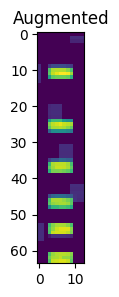

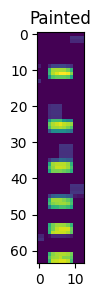

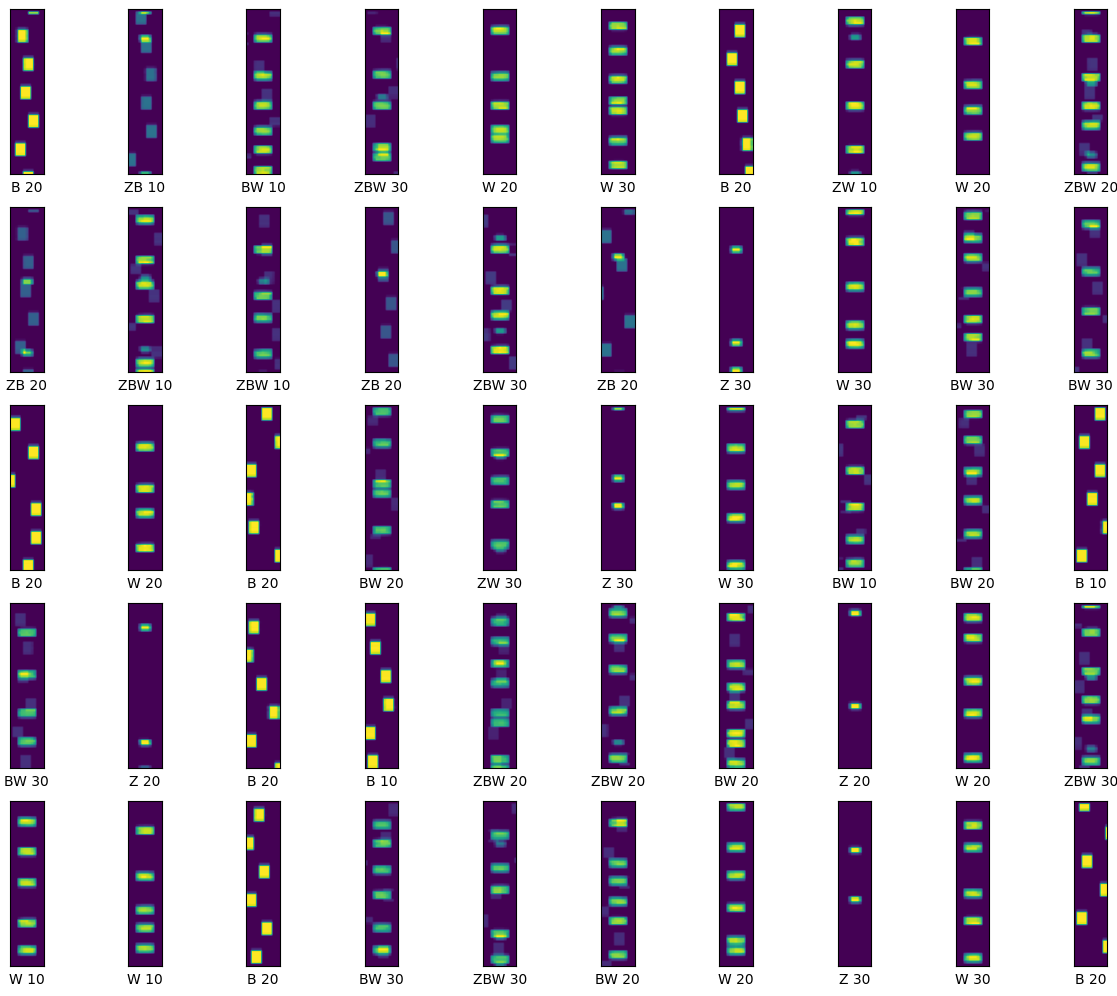

In [17]:
# Show the distribution
print(sorted(Counter(train_test_sets.y_train).items()))
print(sorted(Counter(train_test_sets.y_test).items()))

plt.figure(figsize=(3, 3))
plt.title("Augmented")
plt.imshow(train_test_sets.x_test_augmented[2], cmap='viridis')
plt.show()

plt.figure(figsize=(3, 3))
plt.title("Painted")
plt.imshow(train_test_sets.x_test_painted[2], cmap='viridis')
plt.show()

sp_plot.plot_train_images(train_test_sets.x_test_painted,
                          train_test_sets.y_test,
                          train_test_sets.label_names,
                          train_test_sets.test_snr)

# Create TensorFlow model

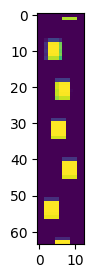

(64, 13)
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 64, 13, 1)]          0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 64, 13, 1)]          0         []                            
                                                                                                  
 conv2d_6 (Conv2D)           (None, 64, 13, 8)            400       ['input_3[0][0]']             
                                                                                                  
 conv2d_9 (Conv2D)           (None, 64, 13, 8)            400       ['input_4[0][0]']             
                                                                                   

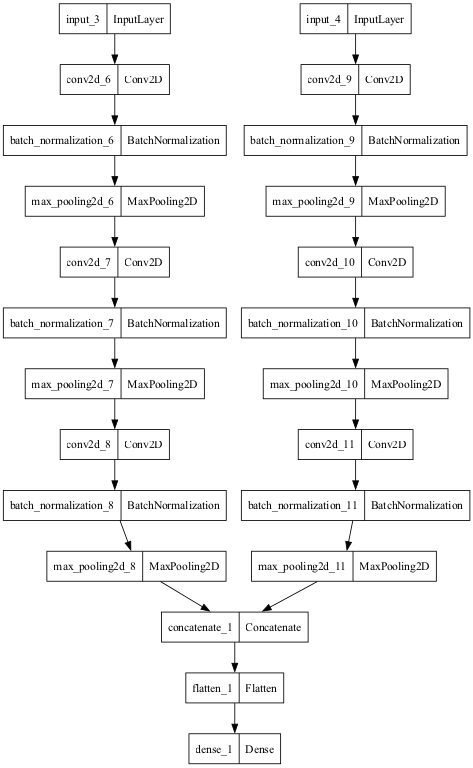

In [18]:
reload(sp_model)

plt.figure(figsize=(3, 3))
plt.imshow(train_test_sets.x_test_painted[0], cmap='viridis')
plt.show()

image_shape = train_test_sets.x_train_augmented[0].shape
print(image_shape)

tf_model = sp_model.create_tensorflow_model(image_shape=image_shape, label_count=len(train_test_sets.label_names))
tf_model.summary()
tf.keras.utils.plot_model(tf_model, to_file="output/model.png", dpi=60)


# Train the TensorFlow model

 Epoch: 194, Val. accuracy = 0.9895833134651184

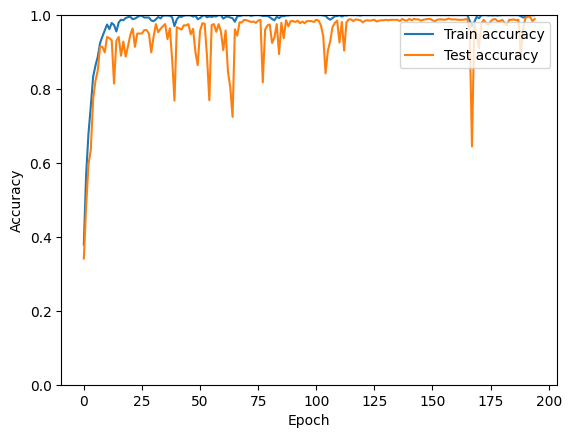

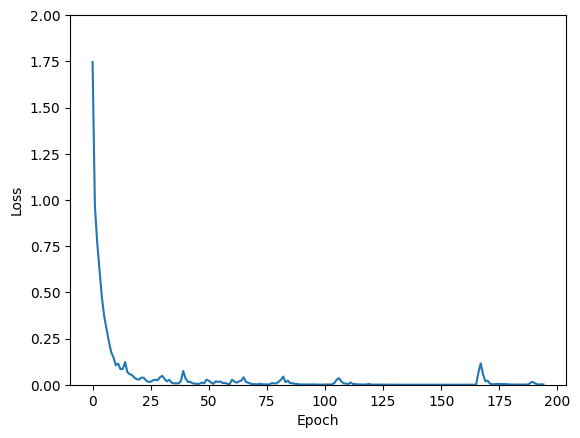

Final loss: 0.026227, final accuracy: 0.989583
INFO:tensorflow:Assets written to: output/assets


INFO:tensorflow:Assets written to: output/assets


In [19]:
reload(sp_model)
history = sp_model.fit_model(tf_model, train_test_sets, epochs=200, early_stopping_patience=30)

sp_plot.plot_model_accuracy_epochs(history)
sp_plot.plot_model_loss(history)

final_loss, final_acc = tf_model.evaluate([train_test_sets.x_test_augmented, train_test_sets.x_test_painted],
                                          train_test_sets.y_test,
                                          verbose=0)
print("Final loss: {0:.6f}, final accuracy: {1:.6f}".format(final_loss, final_acc))

output_file = f"output/spectrum-painting-model-SNR-all.keras"

tf.saved_model.save(tf_model, "output/")
tf_model.save(output_file)

# Confusion matrix for TensorFlow model

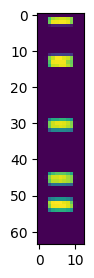

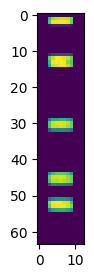

W


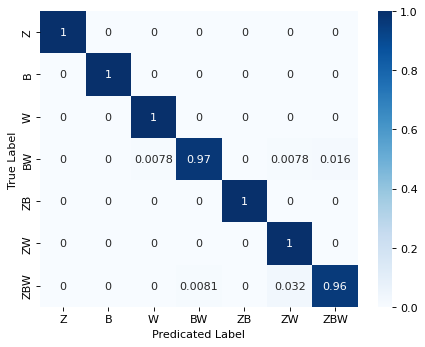

In [21]:
reload(sp_predict)
reload(sp_plot)

# Predict with full Tensorflow
test_img_augmented = train_test_sets.x_test_augmented[17]
test_img_painted = train_test_sets.x_test_painted[17]

plt.figure(figsize=(3, 3))
plt.imshow(test_img_augmented, cmap='viridis')
plt.show()

plt.figure(figsize=(3, 3))
plt.imshow(test_img_painted, cmap='viridis')
plt.show()

prediction = sp_predict.predict_full_model(tf_model, test_img_augmented, test_img_painted)

print(train_test_sets.label_names[prediction])

tf_model_y_predictions = [sp_predict.predict_full_model(tf_model, x_a, x_p) for (x_a, x_p) in
                          zip(train_test_sets.x_test_augmented, train_test_sets.x_test_painted)]

sp_plot.plot_confusion_matrix(tf_model_y_predictions, train_test_sets.y_test, train_test_sets.label_names)

# Convert to Lite model

In [27]:
reload(sp_model)
tflite_model = sp_model.convert_to_tensorflow_lite(tf_model,
                                                   train_test_sets.x_test_augmented,
                                                   train_test_sets.x_test_painted)
print(f"Done. Model size = {len(tflite_model) // 1000} KB")

lite_output_file = f"output/spectrum-painting-model.tflite"
# Save the model.
with open(lite_output_file, "wb") as f:
    f.write(tflite_model)

# Create a hex dump of the model in a C file for the arduino.
# Use sed to make the variables const since they are huge.
! xxd -i $lite_output_file | sed -e "s/unsigned/const unsigned/"  > ../arduino/spectrum_painting/model.h

INFO:tensorflow:Assets written to: /var/folders/81/3wz7wxg90f3df6qvy1xbf71m0000gn/T/tmpuviqw5dd/assets


INFO:tensorflow:Assets written to: /var/folders/81/3wz7wxg90f3df6qvy1xbf71m0000gn/T/tmpuviqw5dd/assets
/Users/sethd/Desktop/spectrum-painting/venv/lib/python3.10/site-packages/tensorflow/lite/python/convert.py:947: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
2024-06-01 13:56:04.177524: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-06-01 13:56:04.177540: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-06-01 13:56:04.177663: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/folders/81/3wz7wxg90f3df6qvy1xbf71m0000gn/T/tmpuviqw5dd
2024-06-01 13:56:04.179663: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-06-01 13:56:04.179669: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /var/folders/81/3wz7wxg90f3

Done. Model size = 19 KB


fully_quantize: 0, inference_type: 6, input_inference_type: UINT8, output_inference_type: UINT8


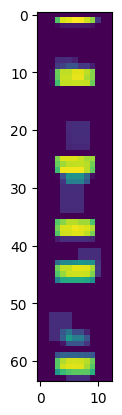

ZBW
Prediction: ZW


In [28]:
reload(sp_predict)
image_index = 9

# Test with Tensorflow Lite
test_img_augmented = train_test_sets.x_test_augmented[image_index]
test_img_painted = train_test_sets.x_test_painted[image_index]

plt.imshow(test_img_augmented, cmap="viridis")
plt.show()
print(train_test_sets.label_names[train_test_sets.y_test[image_index]])

prediction = sp_predict.predict_lite_model(tflite_model, test_img_augmented, test_img_painted)
print(f"Prediction: {train_test_sets.label_names[prediction]}")

# Confusion matrix for Lite model

Lite model accuracy = 0.9537037037037037


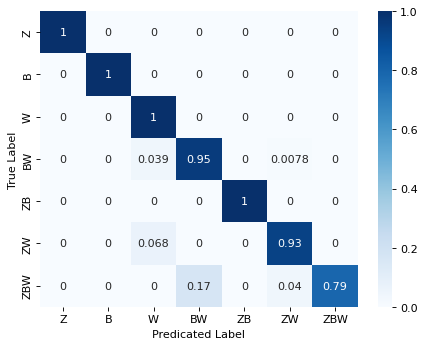

In [29]:
tflite_model_y_predictions: List[int] = []

for x_aug, x_painted in list(zip(train_test_sets.x_test_augmented, train_test_sets.x_test_painted)):
    tflite_model_y_predictions.append(sp_predict.predict_lite_model(tflite_model, x_aug, x_painted))

tflite_accuracy = np.sum(train_test_sets.y_test == tflite_model_y_predictions) / len(train_test_sets.y_test)

print(f"Lite model accuracy = {tflite_accuracy}")
sp_plot.plot_confusion_matrix(np.asarray(tflite_model_y_predictions), train_test_sets.y_test,
                              train_test_sets.label_names)

# Test Lite model and save test images for Arduino

(64, 13)
Label index 1
Label B


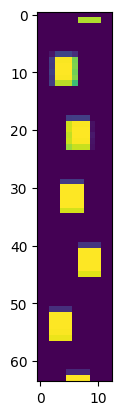

In [30]:
image_index = 0

test_img_augmented = train_test_sets.x_test_augmented[image_index]
test_img_painted = train_test_sets.x_test_painted[image_index]

print(test_img_augmented.shape)
print(f"Label index {train_test_sets.y_test[image_index]}")
print(f"Label {train_test_sets.label_names[train_test_sets.y_test[image_index]]}")

plt.imshow(test_img_augmented, cmap='viridis')
plt.show()

test_img_augmented.shape += (1,)
test_img_augmented = (np.expand_dims(test_img_augmented, 0))
test_img_augmented = test_img_augmented.astype(np.uint8)

test_img_painted.shape += (1,)
test_img_painted = (np.expand_dims(test_img_painted, 0))
test_img_painted = test_img_painted.astype(np.uint8)

with open('output/augmented_image.bytes', 'wb') as f:
    f.write(test_img_augmented.flatten())

with open('output/painted_image.bytes', 'wb') as f:
    f.write(test_img_painted.flatten())

# Create a hex dump of the image in a C file for the arduino.
! xxd -i output/augmented_image.bytes | sed -e "s/unsigned/const unsigned/"  > ../arduino/spectrum_painting/painted_image.h
! xxd -i output/painted_image.bytes | sed -e "s/unsigned/const unsigned/"  > ../arduino/spectrum_painting/augmented_image.h

# Compile and upload to arduino

In [ ]:
! arduino-cli compile --fqbn arduino:mbed:nano33ble ../arduino/spectrum_painting/spectrum_painting.ino
! arduino-cli upload --fqbn arduino:mbed:nano33ble ../arduino/spectrum_painting/spectrum_painting.ino --port /dev/cu.usbmodem1101

serial = Serial(port="/dev/cu.usbmodem2101", baudrate=9600, timeout=1000)

prediction = int(serial.readline().strip())
time = int(serial.readline().strip())
print(f"Full accuracy = {final_acc}")
print(f"Lite model size = {len(tflite_model) / 1000} KB, Lite accuracy = {tflite_accuracy}")
print(f"Prediction = {train_test_sets.label_names[prediction]}, Time = {time}ms")